In [28]:
import pandas as pd
import numpy as np

import warnings
import psutil, os
warnings.filterwarnings('ignore')

X = pd.read_pickle('labeled_mh_r1.pkl')
X.shape

(2540268, 14)

In [29]:
# get a sample of ten percent of the data

X_sample = X.sample(frac=.1, random_state=37)
X_sample.shape

(254027, 14)

In [36]:
# going to only cluster lat/long values

coords = X_sample[["latitude", "longitude"]]

In [37]:
coords.head()

,latitude,longitude
284501,44.405499,-121.777298
189876,38.113899,-96.793297
2367015,64.370796,-155.065094
1195401,29.773001,-90.734596
892436,39.016800,-97.508598


In [8]:
!pip install hdbscan

In [38]:
# hdbscan

import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20, gen_min_span_tree=True)
clusterer.fit(coords)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=50, min_samples=20, p=None,
    prediction_data=False)

In [39]:
labels = clusterer.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 930
Estimated number of noise points: 82312


In [40]:
# add column of cluster labels to dataframe

coords['clusters'] = clusterer.labels_

In [41]:
coords.head()

,latitude,longitude,clusters
284501,44.405499,-121.777298,534
189876,38.113899,-96.793297,-1
2367015,64.370796,-155.065094,73
1195401,29.773001,-90.734596,-1
892436,39.016800,-97.508598,774


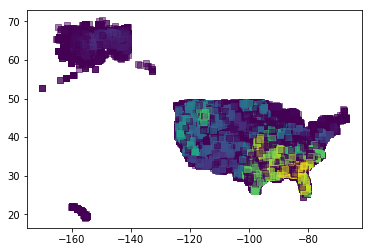

In [55]:
# attempting to visualize our clusters

import matplotlib.pyplot as plt

plt.scatter(coords["longitude"], coords["latitude"], alpha=.5, marker=',', c=coords["clusters"])
plt.show()

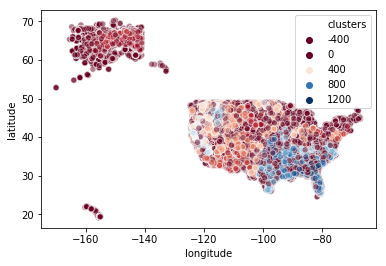

In [72]:
import seaborn as sns

ax = sns.scatterplot(x="longitude", y="latitude", hue="clusters", 
                     data=coords, markers=",", alpha=.5, palette="RdBu")

In [42]:
# merge coords back onto sample dataframe including cluster column

X_sample = pd.merge(X_sample, coords, how="left", on=["latitude", "longitude"])
X_sample.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,bright_t31,frp,daynight,fire,clusters
0,44.405499,-121.777298,365.200012,1.2,1.1,2003-08-20,2123,Aqua,100,modis,305.700012,126.699997,D,1,534
1,38.113899,-96.793297,304.500000,3.9,1.8,2003-04-21,1635,Terra,59,modis,291.899994,30.600000,D,0,-1
2,64.370796,-155.065094,318.899994,1.0,1.0,2015-06-24,2235,Aqua,57,modis,300.399994,12.700000,D,1,73
3,29.773001,-90.734596,301.799988,1.5,1.2,2007-12-04,1900,Aqua,38,modis,288.799988,7.600000,D,0,-1
4,39.016800,-97.508598,330.399994,1.3,1.1,2006-07-15,1742,Terra,70,modis,308.299988,23.400000,D,0,774


In [74]:
# now lets bring in sample real time data and see if it clusters similarly

modis_url = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/c6/csv/MODIS_C6_USA_contiguous_and_Hawaii_24h.csv'

rt_data = pd.read_csv(modis_url)
print(rt_data.shape)
rt_data.head()

(543, 13)


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,bright_t31,frp,daynight
0,38.696,-90.138,308.1,1.1,1.1,2019-09-19,415,T,74,6.0NRT,295.2,8.7,N
1,38.285,-94.528,317.6,1.0,1.0,2019-09-19,415,T,95,6.0NRT,293.0,16.0,N
2,19.018,-88.364,324.4,1.0,1.0,2019-09-19,410,T,100,6.0NRT,293.8,21.1,N
3,18.946,-88.982,304.9,1.0,1.0,2019-09-19,410,T,62,6.0NRT,294.9,4.6,N
4,18.956,-88.974,310.7,1.0,1.0,2019-09-19,410,T,81,6.0NRT,295.2,8.4,N


In [85]:
# trying to classify the cluster for rt data based on trained clusters

from sklearn.ensemble import RandomForestClassifier

features = ["latitude", "longitude"]

X_train = X_sample[features]
y_train = X_sample["clusters"]

X_test = rt_data[features]
#y_test = rt_data["clusters"]

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
clf.predict(X_test)

array([330,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 854, 884, 804,  -1,
        -1,  -1, 170,  -1,  -1, 157,  -1,  -1, 378, 378, 378, 378, 378,
       378,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1, 378,  -1,  15,  -1,  -1,  -1, 277, 277,  -1, 277,  -1,
        -1, 138, 138, 206, 206, 276, 307, 276,  -1,  -1,  -1,  -1,  -1,
        -1, 624, 624,  -1,  -1,  -1,  -1, 796, 742, 742, 742,  -1,  -1,
       742,  -1,  -1, 796, 796,  -1, 736,  -1,  -1,  -1,  -1,  -1,  -1,
       821,  -1, 917, 899,  -1,  -1, 899, 783, 783, 897, 897,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 927,  -1,  -1,  -1,
        -1,  -1, 922, 922,  -1, 921,  -1, 877,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 294, 294,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 178, 178, 159, 159,  -1,
        -1,  -1,   7,   7,   7,   7,   7, 134, 624,  -1,  -1,  51, 277,
        -1,  25,  -1,  -1, 742,  -1,  -1,  -1,  -1,  -1,  -1,  -

In [86]:
rt_data["clusters"] = clf.predict(X_test)
rt_data.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,bright_t31,frp,daynight,clusters
0,38.696,-90.138,308.1,1.1,1.1,2019-09-19,415,T,74,6.0NRT,295.2,8.7,N,330
1,38.285,-94.528,317.6,1.0,1.0,2019-09-19,415,T,95,6.0NRT,293.0,16.0,N,-1
2,19.018,-88.364,324.4,1.0,1.0,2019-09-19,410,T,100,6.0NRT,293.8,21.1,N,-1
3,18.946,-88.982,304.9,1.0,1.0,2019-09-19,410,T,62,6.0NRT,294.9,4.6,N,-1
4,18.956,-88.974,310.7,1.0,1.0,2019-09-19,410,T,81,6.0NRT,295.2,8.4,N,-1


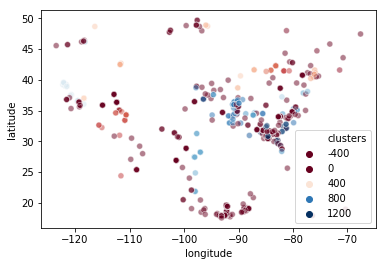

In [88]:
# visualize new clusters

ax = sns.scatterplot(x="longitude", y="latitude", hue="clusters", 
                     data=rt_data, markers=",", alpha=.5, palette="RdBu")

In [99]:
# lets cross validate before trying on real time data

# imports
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from statistics import mean

# defaults
tscv = TimeSeriesSplit(n_splits=3)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall']

X = X_sample.drop(columns="fire")
y = X_sample["fire"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [97]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

features = ["latitude", "longitude", "brightness", "scan", "track", "acq_time", "confidence", "bright_t31", "frp", "clusters"]

X_train = X_train[features]
#y_train = y_train["fire"]

X_test = X_test[features]
#y_test = y_test["fire"]

lr = LogisticRegression()
lr.fit(X_train, y_train)
scores = cross_validate(lr, X_test, y_test, scoring=scoring, cv=tscv)

lr_accuracy = scores["test_accuracy"].mean()
lr_f1 = scores["test_f1"].mean()
lr_roc_auc = scores["test_roc_auc"].mean()
lr_recall = scores["test_recall"].mean()

print("Average Test Accuracy: ", lr_accuracy)
print("Average Test F1: ", lr_f1)
print("Average Test ROC AUC: ", lr_roc_auc)
print("Average Test Recall: ", lr_recall)

Average Test Accuracy:  0.9064081706435285
Average Test F1:  0.9500631448520486
Average Test ROC AUC:  0.7966799963813539
Average Test Recall:  0.9880076760601023


In [100]:
# lets look at scores without using our clusters data

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

features = ["latitude", "longitude", "brightness", "scan", "track", "acq_time", "confidence", "bright_t31", "frp"]

X_train = X_train[features]
#y_train = y_train["fire"]

X_test = X_test[features]
#y_test = y_test["fire"]

lr = LogisticRegression()
lr.fit(X_train, y_train)
scores = cross_validate(lr, X_test, y_test, scoring=scoring, cv=tscv)

lr_accuracy = scores["test_accuracy"].mean()
lr_f1 = scores["test_f1"].mean()
lr_roc_auc = scores["test_roc_auc"].mean()
lr_recall = scores["test_recall"].mean()

print("Average Test Accuracy: ", lr_accuracy)
print("Average Test F1: ", lr_f1)
print("Average Test ROC AUC: ", lr_roc_auc)
print("Average Test Recall: ", lr_recall)

Average Test Accuracy:  0.9036458333333334
Average Test F1:  0.9492053363063763
Average Test ROC AUC:  0.772483265266151
Average Test Recall:  0.9990878865087538


In [98]:
# now lets try on real time data

X_train = X_sample[features]
y_train = X_sample["fire"]

X_test = rt_data[features]
#y_test = y_test["fire"]

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,